In [37]:
#Download data from LIGO server

import sys
!{sys.executable} -m pip install lalsuite pycbc
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



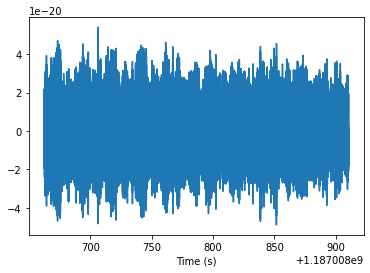

In [38]:
#Load strain data

%matplotlib inline
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger( "GW170817" )
strain, stilde = {}, {}
for ifo in [ 'H1' , 'L1' ]:
# We'll download the data and select 256 seconds that includes the event time
  ts = read_frame( "{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf" . format (ifo[ 0 ], ifo),
           '{}:LOSC-STRAIN' . format (ifo),
           start_time=merger.time - 224 ,
           end_time=merger.time + 32 ,
           check_integrity= False )
   
# Remove the low frequency content and downsample the data to 2048Hz
  strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
# Remove time corrupted by the high pass filter
  strain[ifo] = strain[ifo].crop( 4 , 4 )
# Also create a frequency domain version of the data
  stilde[ifo] = strain[ifo].to_frequencyseries()


#print (strain.delta_t)
pylab.plot(strain[ 'H1' ].sample_times, strain[ 'H1' ])
pylab.xlabel( 'Time (s)' )
pylab.show()

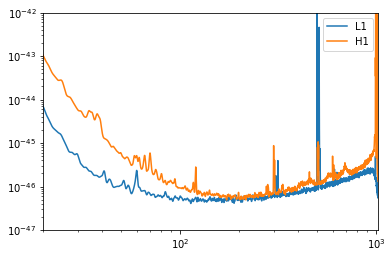

In [39]:
#first plot the power spectral density of the data
#it is important to whiten the data or in order to find the SNR
import pycbc.psd
from pycbc.psd import interpolate, inverse_spectrum_truncation

psds = {}
for ifo in ['L1', 'H1']:
# Calculate a psd from the data. We'll use 2s segments in a median -welch style estimate
# We then interpolate the PSD to the desired frequency step.
  psds[ifo] = interpolate(strain[ifo].psd(2), stilde[ifo].delta_f)
# We explicitly control how much data will be corrupted by overwhitening the data later on
# In this case we choose 2 seconds.
  psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 *
                                                         strain[ifo].sample_rate),
                                          low_frequency_cutoff=15.0,
                                          trunc_method='hann')

  pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
  pylab.xlim(20, 1024)
  pylab.ylim(1e-47, 1e-42)
pylab.legend()

In [40]:
#Matched Filtering

from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

# We will try different component masses and see which gives us the largest 
masses = numpy.arange(1.3, 1.5, .01)

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []


for m in masses:
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                     mass1=m,
                     mass2=m,
                     delta_f=stilde[ifo].delta_f,
                     f_lower=20)

    # We will resize the vector to match our data
    hp.resize(len(stilde[ifo]))

    # Matched filter the data and find the peak
    max_snr, max_time = {}, {}
    for ifo in ['L1', 'H1']:
      snr = matched_filter(hp, stilde[ifo], psd=psds[ifo],
      low_frequency_cutoff=20.0)
    # The complex SNR at the peak
      snr = snr.time_slice(merger.time - 1, merger.time + 1)
      _, idx = snr.abs_max_loc()
      max_snr[ifo] = snr[idx]

    # The time of the peak
      max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time

    network_snr = (abs(numpy.array(list(max_snr.values()))) ** 2.0).sum()** 0.5
    snrs.append(max_snr)
  # Keep track of only the loudest peak
    if network_snr > nsnr:
      tmax, hmax, mmax, smax = max_time, hp, m, max_snr
      nsnr = network_snr



# See the SNR as a function of the component mass. Notice where this peaksas it gives us
# an estimate of what the parameters of the source system are. Note thatmasses
# here are in the *detector* frame, so if the source is located far away,it will in
# fact correspond to a lighter system due to cosmological redshift.
print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mmax)




We found the best Mass1=Mass2 was 1.38 solar masses (detector frame)


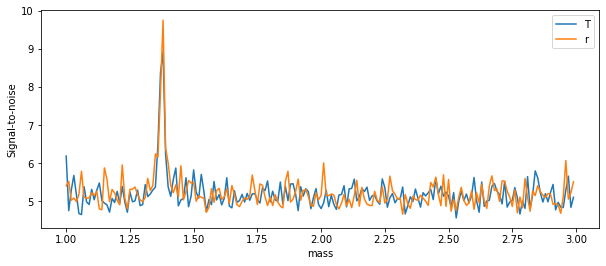

In [41]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

# We will try different component masses and see which gives us the largest 
#chirp_mass = numpy.arange(35, 37\, .1)
#masses = mass1_from_mchirp_q(chirp_mass, 1)
mass1 = numpy.arange(1, 3,0.01 ) #mass range bewteen 30 to 40 Solar mass
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                     mass1=m,
                     mass2=m,
                     delta_f=stilde[ifo].delta_f,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(stilde[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list



ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                     mass1=m,
                     mass2=m,
                     delta_f=strain[ifo].delta_f,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(stilde[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, stilde[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

In [42]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower


f_low = 30
sample_rate = 4096
m_list = []
i_list = []
mass_list = []

# Generate the two waveforms to compare
hp, hc = get_td_waveform(approximant = "EOBNRv2" ,
                         mass1 = 10 ,
                         mass2 = 10 ,
                         f_lower = f_low,
                         delta_t = 1.0 / sample_rate)

for mass in numpy.arange(5, 15,0.1 ):
  sp, sc = get_td_waveform(approximant = "TaylorT4" ,
                           mass1 = mass,
                           mass2 = mass,
                           f_lower = f_low,
                           delta_t = 1.0 / sample_rate)


# Resize the waveforms to the same length
  tlen = max ( len (sp), len (hp))
  sp . resize(tlen)
  hp . resize(tlen)

# Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp . duration
  flen = tlen // 2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)


# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
  m, i = match(hp, sp, psd = psd, low_frequency_cutoff = f_low)
  m_list.append(m)
  i_list.append(i)
  mass_list.append(mass)


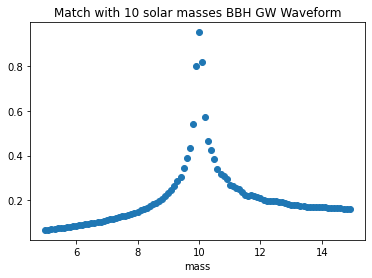

In [43]:
import matplotlib.pyplot as plt

plt.title("Match with 10 solar masses BBH GW Waveform")
plt.xlabel("mass")
plt.scatter(mass_list, m_list)



In [44]:
import numpy as np
d = np.load('noise_ts_4096Hz.npy')
import pycbc.types 
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
Data = d


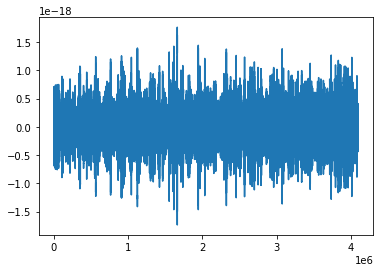

In [45]:
plt.plot(Data)

In [46]:
from pycbc.psd import welch, interpolate
psds = interpolate(welch(d), 1.0 / d.duration)

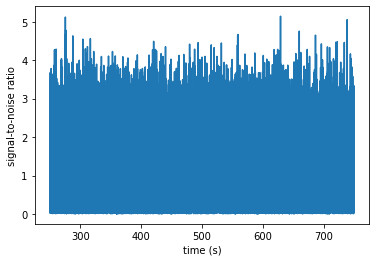

Maximum SNR 5.14255771068566


IndexError: ignored

In [47]:
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab
flow = 30 #Hz
stilde = Data.to_frequencyseries()


hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                             mass1=10, mass2=10,
                             f_lower=flow, delta_f=stilde.delta_f)

hp.resize(len(stilde))  
snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                  low_frequency_cutoff=flow)


# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()
print ( 'Maximum SNR', max(abs(snr)) )

white_data = (Data.to_frequencyseries() / psds[ifo]** 0.5 ).to_timeseries()


In [ ]:
import matplotlib.pyplot as plt

x = range(-200,200,5)

plt.title("IQ Histogram")
plt.hist(white_data, x)


plt.show()

In [48]:
import pycbc.psd
import numpy as np
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

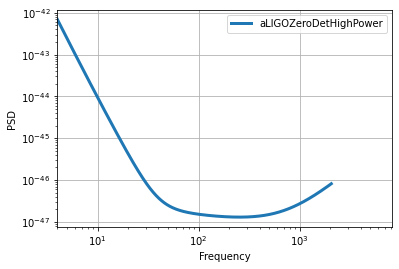

In [49]:
import pycbc.noise
import pycbc.psd
import pylab

# generate some colored gaussian noise

pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='aLIGOZeroDetHighPower')


pylab.xlim(xmin=flow, xmax=8192)
pylab.xlabel('Frequency')
pylab.ylabel('PSD')
pylab.legend()
pylab.grid()
pylab.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


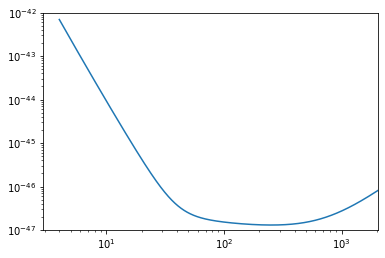

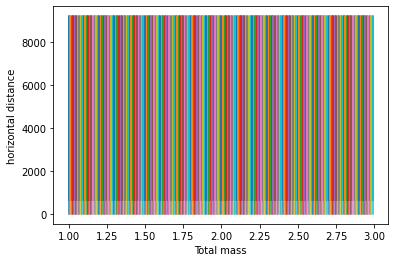

In [50]:
import pycbc.psd
import numpy as np

flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1

psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(0, max(psd.sample_frequencies))
pylab.ylim(1e-47, 1e-42)
pylab.show()
from pycbc.filter import sigmasq

flow = 4.0 #Hz

interval = 1
masses = np.arange(5,550,interval)

a = []
b = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))*0.5

  if SNR > 8: 
    a.append(SNR/8)
    b.append(mass2)

pylab.plot(b, a)
pylab.ylabel('horizontal distance')
pylab.xlabel('Total mass')
pylab.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


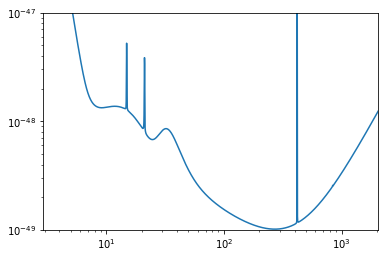

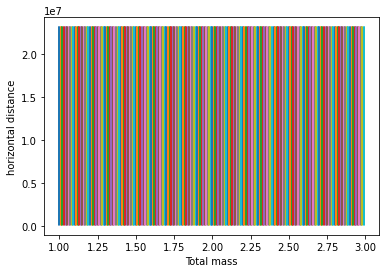

In [52]:
psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# print(psd.sample_frequencies)

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(min(psd.sample_frequencies), max(psd.sample_frequencies))
pylab.ylim(1e-49, 1e-47)
pylab.show()

interval = 1
masses = np.arange(5,550,interval)

a = []
b = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))*0.5

  if SNR > 8: 
    a.append(SNR/8)
    b.append(mass2)

pylab.plot(b, a)
pylab.ylabel('horizontal distance')
pylab.xlabel('Total mass')
pylab.show()